## RBC Model
Working through the RBC model in Alisdair McKay's series on Heterogenous Agent Modeling. The main thing here is the implementation of Linear Time Iteration

In [1]:
# load packages
import matplotlib.pyplot as plt
import jax.numpy as jnp
import warnings
import jax
jax.config.update('jax_enable_x64', True)  # jax uses 32 bit numbers for some reason

# config
ALPHA = 1/3
BETA = 0.99
GAMMA = 2
DELTA = 0.1
L_BAR = 1
RHO_Z = 0.8
SIGMA_Z = 0.02

#### The Model
We have a model with a representative agent where preferences are given by the CRRA utility function
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t \frac{C_t^{1-\gamma}}{1-\gamma},
$$
production follows the Cobb-Douglas production function
$$
Y_t = Z_t K_{t-1}^\alpha \overline{L}_t^{1-\alpha},
$$
capital follows
$$
K_t = (1-\delta) K_{t-1} + Y_t - C_t,
$$
and aggregate productivity follows the AR(1) process
$$
\log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_t
$$
where $\varepsilon_t \sim \mathcal{N}(0, \sigma_Z)$.

To simplify the model, we'll also define
$$
R_t = \alpha K_{t-1}^{\alpha-1} \overline{L}^{1-\alpha} + 1 - \delta.
$$

The variables in the model represent
| Variable | Meaning |
| --- | --- |
| $C_t$ | Consumption at time $t$ |
| $Y_t$ | Output at time $t$ |
| $K_t$ | Capital stock at time $t$ |
| $R_t$ | Rental rate of capital at time $t$ |
| $Z_t$ | Productivity multiplier at time $t$ |

and the parameters in the model represent
| Parameter | Meaning |
| --- | --- |
| $\beta$ | Intertemporal discount factor |
| $\gamma$ | Risk aversion parameter |
| $\alpha$ | Cobb Douglas parameter |
| $\overline{L}$ | Fixed labor supply |
| $\delta$ | Capital depreciation rate |
| $\rho_Z$ | Regression to mean (1) of aggregate production |
| $\sigma_Z$ | Standard deviation of $Z$ shocks |

The model is characterized by the system
\begin{align}
C_t^{-\gamma} &= \beta R_{t+1} C_{t+1}^{-\gamma} \\
R_t &= \alpha K_{t-1}^{\alpha-1} \overline{L}^{1-\alpha} + 1 - \delta \\
Y_t &= Z_t K_{t-1}^\alpha \overline{L}_t^{1-\alpha} \\
K_t &= (1-\delta) K_{t-1} + Y_t - C_t \\
\log Z_t &= \rho_Z \log Z_{t-1} + \varepsilon_t
\end{align}
where (1) comes from taking
\begin{align*}
\max_{\{C_t, K_t, Y_t\}_{t=0}^\infty} \quad & \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{C_t^{1-\gamma}}{1-\gamma} \\
\text{subject to} \quad & K_t = (1-\delta) K_{t-1} + Y_t - C_t \\
& Y_t = Z_t K_{t-1}^\alpha \overline{L}_t^{1-\alpha}
\end{align*}
and creating the Lagrangian
$$
\mathcal{L} = \mathbb{E} \sum_{t=0}^\infty \beta^t \left(\frac{C_t^{1-\gamma}}{1-\gamma} - \Lambda_t \left((1-\delta) K_{t-1} + Z_t K_{t-1}^\alpha \overline{L}_t^{1-\alpha} - C_t - K_t\right)\right)
$$
which has the FOCs
\begin{align*}
\Lambda_t &= C_t^{-\gamma} \\
\Lambda_t &= \beta \Lambda_{t+1} \left(\alpha K_t^{\alpha-1} \overline{L}^{1-\alpha} + 1 - \delta\right).
\end{align*}

The steady state of the model is
\begin{align*}
Z &= 1 \\
R &= \frac{1}{\beta} \\
K &= \left(\frac{R - 1 + \delta}{\alpha \overline{L}^{1-\alpha}}\right)^{\frac{1}{\alpha-1}} \\
Y &= K^\alpha \overline{L}^{1-\alpha} \\
C &= Y - \delta K
\end{align*}

#### Setup the Model
To solve the model, we'll need to setup the matrix equation
$$
\mathbf{A} \hat{x}_{t-1} + \mathbf{B} \hat{x}_t + \mathbf{C} \hat{x}_{t-1} + \hat{\varepsilon} = \mathbf{0}
$$
where
$$
\hat{x}_t = \begin{pmatrix} Y_t \\ C_t \\ K_t \\ R_t \\ Z_t \end{pmatrix} - \begin{pmatrix} Y \\ C \\ K \\ R \\ Z \end{pmatrix}
$$

In [2]:
def residual(x_l, x, x_p, err):
    # extract values
    _, _, K_l, _, Z_l = x_l
    Y, C, K, R, Z = x
    _, C_p, _, R_p, _ = x_p
    err_Z, = err

    return jnp.array([
            BETA * R_p * C_p**(-GAMMA) - C**(-GAMMA),  # euler equation
            ALPHA * K_l**(ALPHA-1) * L_BAR**(1-ALPHA) + 1 - DELTA - R,  # rental rate definition
            Z * K_l**ALPHA * L_BAR**(1-ALPHA) - Y,  # production function
            (1-DELTA) * K_l + Y - C - K,  # resource constraint
            RHO_Z * jnp.log(Z_l) + err_Z - jnp.log(Z),  # agregate productivity law of motion
        ])

# get steady states
Z_ss = 1
R_ss = 1/BETA
K_ss = ((R_ss - 1 + DELTA) / (ALPHA * L_BAR**(1-ALPHA)))**(1/(ALPHA - 1))
Y_ss = K_ss**ALPHA * L_BAR**(1-ALPHA)
C_ss = Y_ss - DELTA*K_ss
x_ss = jnp.array([Y_ss, C_ss, K_ss, R_ss, Z_ss])
err_ss = jnp.zeros(1)
assert jnp.isclose(residual(x_ss, x_ss, x_ss, err_ss), 0).all()

# get matricies
A = jax.jacfwd(lambda x_l: residual(x_l, x_ss, x_ss, err_ss))(x_ss)
B = jax.jacfwd(lambda x: residual(x_ss, x, x_ss, err_ss))(x_ss)
C = jax.jacfwd(lambda x_p: residual(x_ss, x_ss, x_p, err_ss))(x_ss)
E = jax.jacfwd(lambda err: residual(x_ss, x_ss, x_ss, err))(err_ss)

#### Linear Time Iteration
We implement linear time iteration from Rendahl (2017). This uses an incremental method to get closer and closer to the policy rule.

In [4]:
def linear_time_iteration(A, B, C, E, max_iter=1000, tol=1e-7):
    '''
    Implentation of Linear Time Iteration from Rendahl (2017) to find
    a policy rule for a dynamic system. 

    Note: This doesn't check BK solutions, so it can output invalid
    policy rules.
    '''
    # intial guess
    P = jnp.zeros_like(A)  # intial guess is all zeros

    # run incremental update algorithms
    for _ in range(max_iter):
        # update rule
        P = -jnp.linalg.inv(B + C@P) @ A

        # exit condition
        diff = jnp.abs(A + B@P + C@P@P).max()
        if diff < tol:
            break
    else:
        warnings.warn('Max iteration count exceeded')

    # get error matrix
    Q = -jnp.linalg.inv(B + C@P) @ E  # @E at the end keeps only releveant columns 

    return P, Q

P, Q = linear_time_iteration(A, B, C, E)

#### Impulse Response
Use our policy rule to simulate the response to an shock.

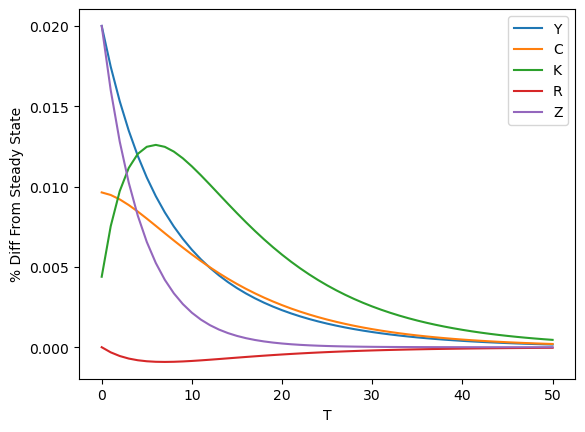

In [5]:
# config
T = 50
res = jnp.zeros((T+1, x_ss.shape[0]))

# simplate it
res = res.at[0, :].set((Q * SIGMA_Z).ravel())
for t in range(1, T+1):
    res = res.at[t, :].set(P @ res[t-1, :])

# plot it
plt.xlabel('T')
plt.ylabel('% Diff From Steady State')
plt.plot(jnp.arange(T+1), res / x_ss, label=['Y', 'C', 'K', 'R', 'Z'])
plt.legend()